       split        MAE        RMSE        R2
0  train_val  44.014324   89.320619  0.551906
1       test  63.339349  175.733244  0.202873


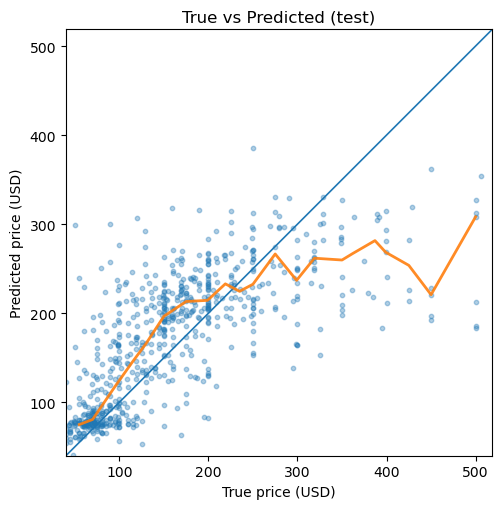

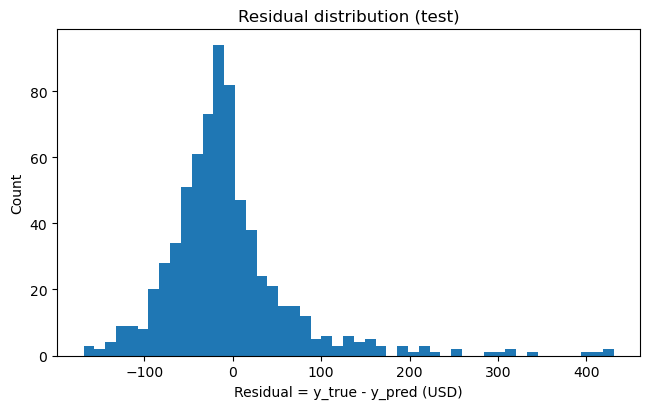

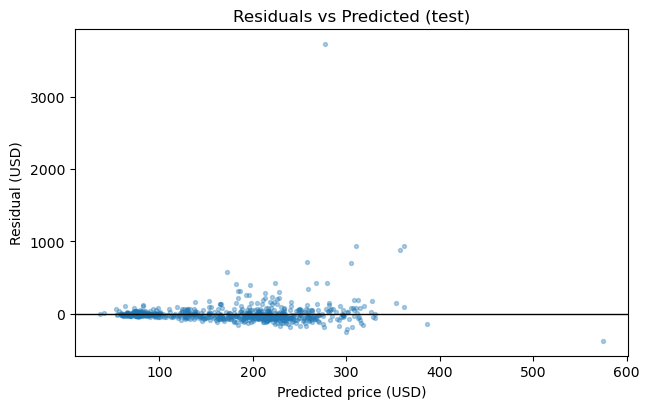

         room_type    n         MAE        RMSE
1     Private room  274   28.912723   44.187157
2      Shared room   14  111.924847  151.613117
0  Entire home/apt  429   83.741909  222.748880


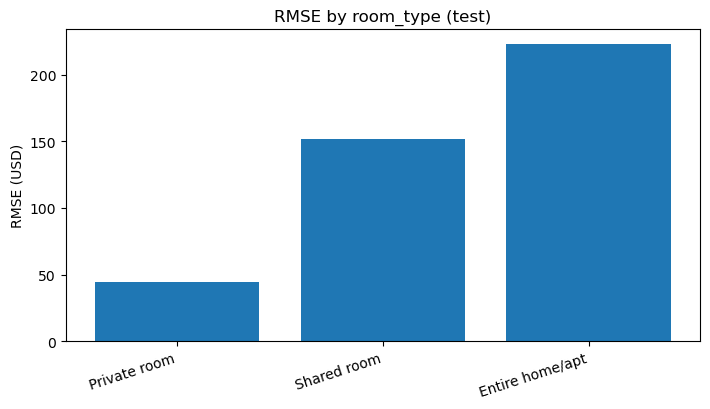

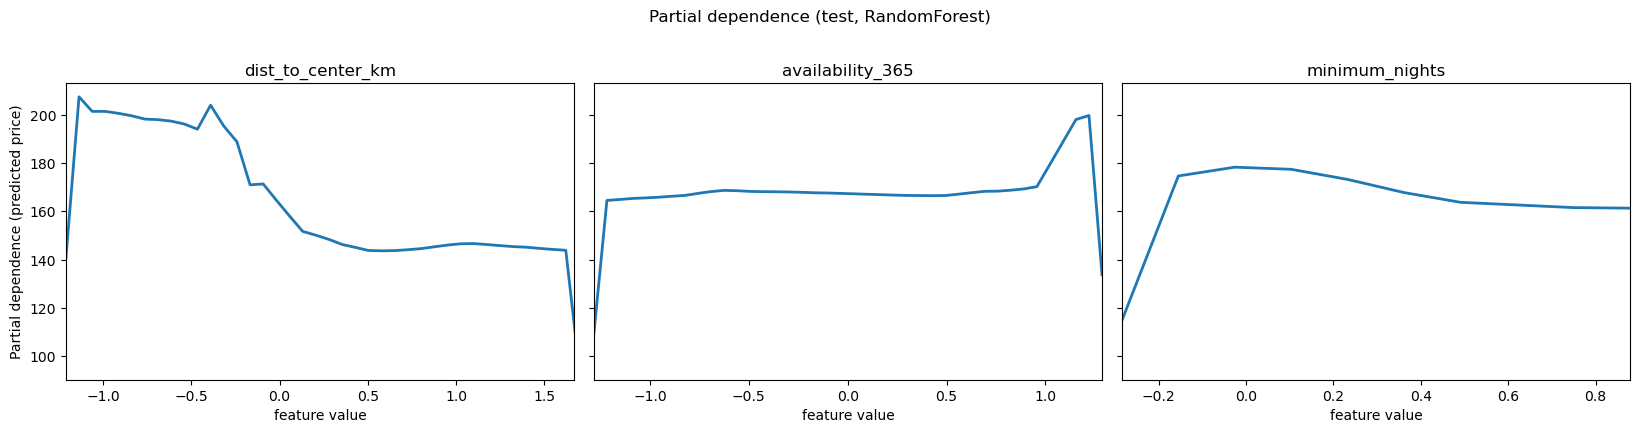

In [6]:
import json, ast
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

ROOT = Path('..')
RES  = ROOT/'results'
FIGS = ROOT/'figures'
RES.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)
FIG_DPI = 300
plt.rcParams.update({'savefig.dpi': FIG_DPI})

X_train = np.load(RES/'X_train.npy'); y_train = np.load(RES/'y_train.npy')
X_val   = np.load(RES/'X_val.npy');   y_val   = np.load(RES/'y_val.npy')
X_test  = np.load(RES/'X_test.npy');  y_test  = np.load(RES/'y_test.npy')
with open(RES/'feature_names.json','r', encoding='utf-8') as f:
    feature_names = json.load(f)

X_tr = np.vstack([X_train, X_val])
y_tr = np.concatenate([y_train, y_val])

def rmse(a, b) -> float:
    return float(np.sqrt(mean_squared_error(a, b)))

rf_params = {"n_estimators": 300, "max_depth": 10, "min_samples_leaf": 5,
             "random_state": 42, "n_jobs": -1}

best_csv = RES/'best_model_test_scores.csv'
if best_csv.exists():
    try:
        df_best = pd.read_csv(best_csv)
        if 'best_model' in df_best.columns and str(df_best.loc[0, 'best_model']) == 'RandomForest':
            if 'best_params' in df_best.columns and isinstance(df_best.loc[0, 'best_params'], str):
                parsed = ast.literal_eval(df_best.loc[0, 'best_params'])
                for k in ['n_estimators', 'max_depth', 'min_samples_leaf', 'random_state']:
                    if k in parsed:
                        rf_params[k] = parsed[k]
    except Exception:
        pass

rf = RandomForestRegressor(**rf_params).fit(X_tr, y_tr)

y_pred_tr   = rf.predict(X_tr)
y_pred_test = rf.predict(X_test)

df_metrics = pd.DataFrame({
    "split": ["train_val", "test"],
    "MAE":   [mean_absolute_error(y_tr, y_pred_tr),  mean_absolute_error(y_test, y_pred_test)],
    "RMSE":  [rmse(y_tr, y_pred_tr),                 rmse(y_test, y_pred_test)],
    "R2":    [r2_score(y_tr, y_pred_tr),             r2_score(y_test, y_pred_test)]
})
df_metrics.to_csv(RES/'error_analysis_overall_metrics.csv', index=False)
print(df_metrics)

plt.figure(figsize=(5.2, 5.2))
both = np.concatenate([y_test, y_pred_test])
lo, hi = np.percentile(both, [1, 99])
lo = max(0.0, float(lo))
hi = float(hi)
mask = (y_test >= lo) & (y_test <= hi) & (y_pred_test >= lo) & (y_pred_test <= hi)
xt, yp = y_test[mask], y_pred_test[mask]
plt.scatter(xt, yp, s=10, alpha=0.35)
plt.plot([lo, hi], [lo, hi], lw=1.2)
bins = np.linspace(lo, hi, 24)
idx = np.digitize(xt, bins)
bin_x = []
bin_y = []
for i in range(1, len(bins)):
    sel = (idx == i)
    if np.any(sel):
        bin_x.append(float(np.median(xt[sel])))
        bin_y.append(float(np.median(yp[sel])))
if len(bin_x) > 1:
    plt.plot(bin_x, bin_y, lw=2, alpha=0.9)
plt.xlim(lo, hi)
plt.ylim(lo, hi)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('True price (USD)')
plt.ylabel('Predicted price (USD)')
plt.title('True vs Predicted (test)')
plt.tight_layout()
plt.savefig(FIGS/'fig_true_vs_pred_test.png', dpi=FIG_DPI)
plt.show()

res_test = y_test - y_pred_test
plt.figure(figsize=(6.6, 4.2))
bins = np.linspace(np.percentile(res_test, 1), np.percentile(res_test, 99), 50)
plt.hist(res_test, bins=bins)
plt.xlabel('Residual = y_true - y_pred (USD)')
plt.ylabel('Count')
plt.title('Residual distribution (test)')
plt.tight_layout()
plt.savefig(FIGS/'fig_residual_hist_test.png')
plt.show()

plt.figure(figsize=(6.6, 4.2))
plt.scatter(y_pred_test, res_test, s=8, alpha=0.35)
plt.axhline(0.0, color='k', lw=1.0)
plt.xlabel('Predicted price (USD)')
plt.ylabel('Residual (USD)')
plt.title('Residuals vs Predicted (test)')
plt.tight_layout()
plt.savefig(FIGS/'fig_residual_vs_pred_test.png')
plt.show()

DATA = ROOT/'data'/'listings.csv'
raw = pd.read_csv(DATA, low_memory=False)

def clean_price(s):
    return (s.astype(str).str.replace(r'[\$,]', '', regex=True)
            .str.replace(r'\.00$', '', regex=True)
            .replace('nan', np.nan).astype(float))
raw['price'] = clean_price(raw['price'])

use_cols = [c for c in [
    'room_type','neighbourhood_cleansed','latitude','longitude',
    'minimum_nights','number_of_reviews','reviews_per_month',
    'availability_365','calculated_host_listings_count'
] if c in raw.columns]

work = raw[['price'] + use_cols].copy()
valid_idx = np.where(work['price'].notna().to_numpy())[0]

idx_train, idx_temp = train_test_split(valid_idx, test_size=0.40, random_state=42)
idx_val,   idx_test = train_test_split(idx_temp,   test_size=0.50, random_state=42)

test_df = work.iloc[idx_test].reset_index(drop=True)
assert len(test_df) == len(y_test), "Index mapping mismatch with step-2 split."

rows = []
if 'room_type' in test_df.columns:
    for g, sub in test_df.groupby('room_type'):
        idx = sub.index.to_numpy()
        rows.append({
            "room_type": g,
            "n": int(len(idx)),
            "MAE": mean_absolute_error(y_test[idx], y_pred_test[idx]),
            "RMSE": rmse(y_test[idx], y_pred_test[idx])
        })
    df_grp = pd.DataFrame(rows).sort_values('RMSE')
    df_grp.to_csv(RES/'error_by_room_type.csv', index=False)
    print(df_grp)

    plt.figure(figsize=(7.2, 4.2))
    order = df_grp['room_type'].tolist()
    plt.bar(order, df_grp['RMSE'])
    plt.ylabel('RMSE (USD)')
    plt.title('RMSE by room_type (test)')
    plt.xticks(rotation=18, ha='right')
    plt.tight_layout()
    plt.savefig(FIGS/'fig_rmse_by_room_type.png')
    plt.show()

top_num_candidates = ['dist_to_center_km','availability_365','minimum_nights','reviews_per_month','number_of_reviews']
top_num = [f for f in top_num_candidates if f in feature_names]
num_indices = [feature_names.index(f) for f in top_num]

try:
    from sklearn.inspection import partial_dependence

    pdp_candidates = ['dist_to_center_km', 'availability_365', 'minimum_nights']
    pick = [feature_names.index(f) for f in pdp_candidates if f in feature_names]
    labels = [feature_names[i] for i in pick]

    if pick:
        n = len(pick)
        fig, axes = plt.subplots(1, n, figsize=(5.5*n, 4.2), sharey=True)
        if n == 1:
            axes = [axes]

        for ax, feat_idx, label in zip(axes, pick, labels):
            pd_res = partial_dependence(
                rf, X=X_test, features=[feat_idx],
                grid_resolution=40, percentiles=(0.05, 0.95)
            )
            grid = pd_res['grid_values'][0] if isinstance(pd_res, dict) else pd_res.grid_values[0]
            pdp  = pd_res['average'][0]     if isinstance(pd_res, dict) else pd_res.average[0]

            if len(pdp) >= 5:
                import numpy as _np
                k = 3
                pdp = _np.convolve(pdp, _np.ones(k)/k, mode='same')

            ax.plot(grid, pdp, lw=2)
            ax.set_xlim(np.percentile(X_test[:, feat_idx], [5, 95]))
            ax.set_title(label)
            ax.set_xlabel('feature value')

            if label == 'dist_to_center_km' and (grid > 0).all():
                pass

        axes[0].set_ylabel('Partial dependence (predicted price)')
        fig.suptitle('Partial dependence (test, RandomForest)', y=1.02, fontsize=12)
        plt.tight_layout()
        plt.savefig(FIGS/'fig_pdp_top3_numeric.png', dpi=FIG_DPI)
        plt.show()
except Exception as e:
    print("[PDP] skipped:", e)

In [ ]:
y_med = float(np.median(y_tr))
mae_b = mean_absolute_error(y_test, np.repeat(y_med, len(y_test)))
rmse_b = np.sqrt(mean_squared_error(y_test, np.repeat(y_med, len(y_test))))
print("Baseline on TEST  ->  MAE:", mae_b, "RMSE:", rmse_b)

Baseline on TEST  ->  MAE: 89.24407252440726 RMSE: 198.7958029465842
